<center> <h1> CmdStanPy goes to the Women's World Cup! </h1> </center>

<figure>
  <center><img src="wwc_2019.jpeg" width = "700"/></center>
</figure>
<center> <h2>#WeStan</h2></center>




<h2> Table of Contents:<a name="TOC"></a></h2>

- [0. Overview](#Intro)
- [1. Importing Packages + Data](#IDA)
- [2. Stan Input](#StanInput)
- [3. Stan Model for the WWC 2019](#StanModel)
- [4. Model Interpretation](#Interpret)
- [5. Visualizations!](#Plots)
- [6.Predictions!](#Pred)
- [7.Make your own tournament!](#Exercises)

<h2> Overview<a name="Intro"></a> </h2>

We're going to look at the Women's World Cup 2019 data up to the semi-finals and use Stan to:

* Estimate the ability of each team
* Predict the winner of the semi-finals
* If time permits, create our own tournament lineups and see how different teams fare against each other!

### The Data

The World Cup is a situation where we don't have a lot of data, which is why this problem is fun/interesting.

Here's the information we have:

* The number of teams participating: 24
* For each of the 24 teams, a pre-world cup estimate of their ability as a Soccer Power Index (spi) score
* The number of matches played up through the end of the quarterfinals round:  48
* For each match, a record containing:
    + identity of team 1
    + identity of team 2
    + goals scored by team 1
    + goals scored by team 2
    
We transform the per-team number of goals scored into a single "score differential": $y = \hbox{score}_1 - \hbox{score}_2$

I.e, if $y > 0$, Team 1 won, if $y == 0$ the game was a tie, if $y < 0$, Team 1 lost.


We code this information in Stan as follows:
```
data {
  int I;   // number of teams
  int N;   // number of matches
  vector[I] prior_score;  // per-team ranking
  // this is a 4-column data table of per-game outcomes
  int team_1[N];
  int team_2[N];
  vector[N] score_1;
  vector[N] score_2;
}
transformed data {
  vector[N] y = score_1 - score_2;  // "modeled" data
}
```

We downloaded this data from [538 by Nate Silver](https://fivethirtyeight.com/methodology/how-our-club-soccer-predictions-work/)

The data is in the csv files:

* [womens_world_cup_2019.csv](../data/womens_world_cup_2019.csv)
* [country_prior.csv](../data/country_prior.csv)

We will take a look at these in a minute.

### The Model

The model we use is inspired by Andrew Gelman's [blog post](https://statmodeling.stat.columbia.edu/2014/07/13/stan-analyzes-world-cup-data/) that he wrote for the FIFA Men's World Cup 2014 games as an exercise in Stan modeling.  This is a very basic model.  We don't recommend using for betting, (unless you're betting against a non-Bayesian).

The model is a simple "Item Response" [IRT](https://mc-stan.org/docs/2_20/stan-users-guide/item-response-models-section.html) model.  This model was developed in the education domain to estimates student ability based on their performance on a series of test questions.  Each student has an ability and each question has a difficulty.
The difference between a student's ability and the question difficulty predicts whether or not the student will answer the question correctly.

In the world cup setting, we're modeling the difference between team 1 and team 2 (as opposed to student and question), but the idea is the same:  the difference between the two team abilities predicts the outcome of the game.

The essential part of this model in Stan is:
```
y ~ student_t(7, ability[team_1] - ability[team_2], sigma_y);
```

This statement says that `y`, (the number of goals scored by team 1 - the number of goals scored by team 2)
is drawn from a Student_t distribution with 7 degrees of freedom.


The complete statement of the parameters and model are:
```
parameters {
  real beta;            // common intercept
  vector[I] alpha;   // vector of per-team weights
  real<lower=0> sigma_a;   // common variance
  real<lower=0> sigma_y;  // noise term in our estimate
}
transformed parameters {
  // "mixed effects" model - common intercept + random effects
  vector[I] ability = beta * prior_score + alpha * sigma_a;
}
model {
  alpha ~ normal(0, 1); // priors on all parameters
  beta ~ normal(0, 2.5);
  sigma_a ~ normal(0, 2.5);
  sigma_y ~ normal(0, 2.5);

  y ~ student_t(7, ability[team_1] - ability[team_2], sigma_y);
}
```


<h2> 1. Importing the Packages and Data!<a name="IDA"></a> </h2>

In [1]:
import cmdstanpy
import pandas as pd
from cmdstanpy import Model, StanFit
import ujson as json

We have two data files; The first one gives us information upto the quarterfinals:

In [2]:
matches = pd.read_csv('../data/womens_world_cup_2019.csv')
matches.head()

,date,match_list,team_1,team_2,score_1,score_2
0,2019-06-07,France vs South Korea,France,South Korea,4.0,0.0
1,2019-06-08,Germany vs China,Germany,China,1.0,0.0
2,2019-06-08,Spain vs South Africa,Spain,South Africa,3.0,1.0
3,2019-06-08,Norway vs Nigeria,Norway,Nigeria,3.0,0.0
4,2019-06-09,Australia vs Italy,Australia,Italy,1.0,2.0


The second one is a list of the countries that participated in the decreasing order of "ability" prior to the tournament. This would be our **prior** here.<br>

We use the *"soccer power index"*, abbreviated here as "spi", as determined at [538 by Nate Silver](https://fivethirtyeight.com/methodology/how-our-club-soccer-predictions-work/). In the stan model, these feature as "prior_score" in the input and as "ability" in the model.

In [3]:
countries = pd.read_csv('../data/country_prior.csv')
countries.head()

,country,spi
0,USA,97.20623
1,France,95.31747
2,Germany,94.17161
3,Australia,93.13200
4,Netherlands,92.70844


We're going to rescale the prior here such that they have a mean of 0! (Ahem, floating points notwithstanding.)

In [4]:
import numpy as np
mean = np.mean(countries['spi'])
std = np.std(countries['spi'])

#Rescaling the prior!
countries['prior_score'] = [(x - mean)/std for x in countries['spi']]

In [5]:
country_mapping = countries.country.to_dict()
country_mapping = {k:v+1 for v,k in country_mapping.items()}

<h2> 2. Inputting the Data to CmdStanPy <a name="StanInput"></a>  </h2>

The input data for the model needs to be in a dictionary format with the following keys: <br>

1. I: The number of teams <br>
2. N: The number of matches played <br>
3. team_1: A column of the "first" team <br>
4. team_2: A column of the "second" team <br>
5. prior_score: The countries' prior scores (i.e., spi's before the tournament) sorted in the descending order <br>

In [6]:
N = len(matches)
I = len(countries)
mydict = dict({'I': I,
               'N': N,
                'team_1': matches['team_1'].values,
               'team_2': matches['team_2'].values,
               'score_1': matches['score_1'].values,
               'score_2': matches['score_2'].values,
              'prior_score': countries['prior_score'].values})

We're now going to refer to the teams by a number that represents their pre-tournament ranking. To do that we first define a dictionary where the keys are the country names and the values are the team ranking.

In [7]:
#Replace team names by their rankings;
mydict['team_1'] = [ country_mapping.get(x) for x in mydict['team_1']]
mydict['team_2'] = [ country_mapping.get(x) for x in mydict['team_2']]

Our data is now prepped. We are ready to model it!

<h2> 3. Stan Model for the Women's World Cup <a name="StanModel"></a> </h2>

In [8]:
stan_wc = Model(stan_file='../models/worldcup_pyladies.stan')
stan_wc.compile()
stan_wc

INFO:cmdstanpy:compiling c++
INFO:cmdstanpy:compiled model file: /Users/nitya/Work/2019-cmdstanpy-bayesian-workshop/models/worldcup_pyladies


Model(name=worldcup_pyladies,  stan_file="../models/worldcup_pyladies.stan", exe_file="/Users/nitya/Work/2019-cmdstanpy-bayesian-workshop/models/worldcup_pyladies")

Now we use the HMC-NUTS sampler to do the estimation:

In [9]:
worldcup_fit = stan_wc.sample(data=mydict, chains=4)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


Now we check that the sampler didn't hit any bumps in the road:

In [10]:
worldcup_fit.diagnose()


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmpqa3kddk_/stan-worldcup_pyladies-draws-1-mhawky8d.csv, /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmpqa3kddk_/stan-worldcup_pyladies-draws-2-cujtp6i_.csv, /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmpqa3kddk_/stan-worldcup_pyladies-draws-3-50ien72o.csv, /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmpqa3kddk_/stan-worldcup_pyladies-draws-4-agg0839l.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

The Stanfit "summary" method gives us a peek into the distributions of all the parameters. CmdStanPy outputs the same as a pandas dataframe for downstream analysis:

In [11]:
df = worldcup_fit.summary().round(decimals = 2)
df

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-52.06,0.28,6.76,-64.17,-51.52,-41.83,563.32,415.10,1.0
beta,0.93,0.01,0.26,0.49,0.94,1.35,1970.62,1452.14,1.0
alpha[1],0.98,0.01,0.69,-0.21,0.97,2.10,3480.07,2564.44,1.0
alpha[2],0.32,0.01,0.64,-0.71,0.31,1.36,3658.38,2695.83,1.0
alpha[3],0.41,0.01,0.65,-0.63,0.42,1.47,3396.48,2502.84,1.0
alpha[4],-0.19,0.01,0.66,-1.22,-0.20,0.90,4370.42,3220.53,1.0
alpha[5],0.48,0.01,0.64,-0.55,0.47,1.50,3948.00,2909.25,1.0
alpha[6],0.57,0.01,0.70,-0.61,0.59,1.65,3262.49,2404.11,1.0
alpha[7],-0.73,0.01,0.71,-1.93,-0.71,0.42,3449.46,2541.88,1.0


<h2> 4. Interpreting the Model Fit <a name="Interpret"></a> </h2>

In [12]:
dft = df.transpose()
ability_filter = [col for col in dft if col.startswith('ability')]
yrep_filter = [col for col in dft if col.startswith('y_rep')]

In [13]:
#Abilities
abilities = dft[ability_filter]
abilities

name,ability[1],ability[2],ability[3],ability[4],ability[5],ability[6],ability[7],ability[8],ability[9],ability[10],...,ability[15],ability[16],ability[17],ability[18],ability[19],ability[20],ability[21],ability[22],ability[23],ability[24]
Mean,2.02,1.28,1.30,0.67,1.29,1.41,0.18,0.67,0.61,1.03,...,-1.07,0.58,-0.60,-0.61,-1.41,-2.12,-0.81,-2.58,-1.11,-0.92
MCSE,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.02,0.01,0.01,0.01,0.01,0.02,0.02,0.01,0.01,0.02
StdDev,0.64,0.56,0.56,0.60,0.56,0.61,0.59,0.59,0.59,0.56,...,0.80,0.63,0.63,0.59,0.64,0.78,0.75,0.79,0.65,0.88
5%,0.99,0.39,0.40,-0.34,0.39,0.44,-0.81,-0.29,-0.38,0.15,...,-2.38,-0.41,-1.62,-1.55,-2.50,-3.44,-1.98,-3.90,-2.17,-2.37
50%,2.02,1.27,1.29,0.69,1.27,1.38,0.18,0.68,0.62,1.01,...,-1.06,0.57,-0.58,-0.62,-1.39,-2.09,-0.83,-2.56,-1.12,-0.93
95%,3.09,2.21,2.22,1.66,2.23,2.47,1.13,1.63,1.57,1.99,...,0.20,1.63,0.41,0.35,-0.39,-0.91,0.46,-1.34,-0.01,0.55
N_Eff,2539.57,4420.14,4239.81,4229.32,4369.11,2656.95,3673.15,4135.96,4152.38,3170.65,...,1569.55,3448.21,4368.69,4845.00,3330.22,1778.96,1933.81,2820.26,3471.69,1397.13
N_Eff/s,1871.39,3257.16,3124.28,3116.55,3219.56,1957.88,2706.71,3047.76,3059.85,2336.42,...,1156.59,2540.96,3219.26,3570.24,2454.01,1310.90,1425.01,2078.23,2558.26,1029.53
R_hat,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [14]:
#Team Differentials
td = dft[yrep_filter]
td

name,y_rep[1],y_rep[2],y_rep[3],y_rep[4],y_rep[5],y_rep[6],y_rep[7],y_rep[8],y_rep[9],y_rep[10],...,y_rep[39],y_rep[40],y_rep[41],y_rep[42],y_rep[43],y_rep[44],y_rep[45],y_rep[46],y_rep[47],y_rep[48]
Mean,2.36,1.34,1.86,0.90,0.09,2.76,2.22,-1.12,1.33,-1.65,...,1.99,0.68,-1.58,0.36,0.69,1.09,-1.11,-0.74,-0.72,0.28
MCSE,0.03,0.03,0.03,0.02,0.03,0.03,0.03,0.04,0.03,0.03,...,0.03,0.02,0.03,0.03,0.03,0.03,0.03,0.03,0.02,0.03
StdDev,1.67,1.65,1.58,1.58,1.69,1.63,1.65,1.73,1.62,1.64,...,1.65,1.61,1.64,1.65,1.65,1.60,1.71,1.64,1.56,1.66
5%,-0.42,-1.34,-0.73,-1.67,-2.54,0.06,-0.42,-3.97,-1.31,-4.27,...,-0.70,-1.92,-4.16,-2.30,-1.93,-1.51,-3.78,-3.36,-3.26,-2.31
50%,2.39,1.35,1.87,0.90,0.04,2.79,2.21,-1.05,1.33,-1.68,...,2.01,0.68,-1.59,0.39,0.67,1.09,-1.11,-0.72,-0.71,0.27
95%,5.00,3.88,4.39,3.41,2.81,5.31,4.88,1.57,3.96,1.03,...,4.56,3.34,1.11,2.97,3.34,3.62,1.62,1.90,1.76,2.93
N_Eff,3238.08,3908.87,3343.02,4304.19,3878.41,3379.24,3892.03,2391.05,3996.42,4298.34,...,4152.36,4341.86,4175.21,3384.18,3810.97,3999.61,4108.68,3841.34,4318.60,4198.18
N_Eff/s,2386.12,2880.41,2463.44,3171.73,2857.97,2490.14,2868.00,1761.94,2944.93,3167.41,...,3059.84,3199.48,3076.68,2493.78,2808.28,2947.28,3027.66,2830.65,3182.34,3093.61
R_hat,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [15]:
td

name,y_rep[1],y_rep[2],y_rep[3],y_rep[4],y_rep[5],y_rep[6],y_rep[7],y_rep[8],y_rep[9],y_rep[10],...,y_rep[39],y_rep[40],y_rep[41],y_rep[42],y_rep[43],y_rep[44],y_rep[45],y_rep[46],y_rep[47],y_rep[48]
Mean,2.36,1.34,1.86,0.90,0.09,2.76,2.22,-1.12,1.33,-1.65,...,1.99,0.68,-1.58,0.36,0.69,1.09,-1.11,-0.74,-0.72,0.28
MCSE,0.03,0.03,0.03,0.02,0.03,0.03,0.03,0.04,0.03,0.03,...,0.03,0.02,0.03,0.03,0.03,0.03,0.03,0.03,0.02,0.03
StdDev,1.67,1.65,1.58,1.58,1.69,1.63,1.65,1.73,1.62,1.64,...,1.65,1.61,1.64,1.65,1.65,1.60,1.71,1.64,1.56,1.66
5%,-0.42,-1.34,-0.73,-1.67,-2.54,0.06,-0.42,-3.97,-1.31,-4.27,...,-0.70,-1.92,-4.16,-2.30,-1.93,-1.51,-3.78,-3.36,-3.26,-2.31
50%,2.39,1.35,1.87,0.90,0.04,2.79,2.21,-1.05,1.33,-1.68,...,2.01,0.68,-1.59,0.39,0.67,1.09,-1.11,-0.72,-0.71,0.27
95%,5.00,3.88,4.39,3.41,2.81,5.31,4.88,1.57,3.96,1.03,...,4.56,3.34,1.11,2.97,3.34,3.62,1.62,1.90,1.76,2.93
N_Eff,3238.08,3908.87,3343.02,4304.19,3878.41,3379.24,3892.03,2391.05,3996.42,4298.34,...,4152.36,4341.86,4175.21,3384.18,3810.97,3999.61,4108.68,3841.34,4318.60,4198.18
N_Eff/s,2386.12,2880.41,2463.44,3171.73,2857.97,2490.14,2868.00,1761.94,2944.93,3167.41,...,3059.84,3199.48,3076.68,2493.78,2808.28,2947.28,3027.66,2830.65,3182.34,3093.61
R_hat,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


<h2> 5. Let's Make Some Plots!<a name="Plots"></a> </h2>

In [16]:
import matplotlib.pyplot as plt
df_teamdifferentials = pd.DataFrame({'midway': td.loc['50%'].values,
                                       'names':matches['match_list']})
df_teamdifferentials.loc[:, 'left'] = td.loc['5%'].values
df_teamdifferentials.loc[:, 'right'] = td.loc['95%'].values

In [17]:
actual_differentials = np.array([matches['score_1'][i]-matches['score_2'][i]  for i in range(len(matches))])

/Users/nitya/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


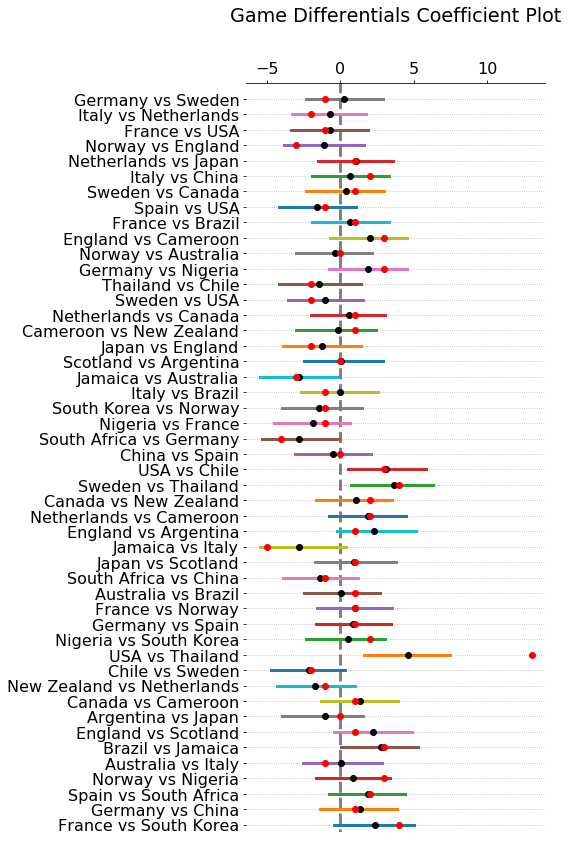

In [18]:
from coefplot import coefficient_plot

coefficient_plot(df_teamdifferentials['midway'], df_teamdifferentials['left'], 
                 df_teamdifferentials['right'], actual_differentials, 
                 names=df_teamdifferentials['names'],
                 title='Game Differentials Coefficient Plot', 
                fig_size = (8,12))
plt.tight_layout()

In [19]:
df_abilities = pd.DataFrame({'midway': abilities.loc['50%'].values,
                                       'names': countries['country']})
df_abilities.loc[:, 'left'] = abilities.loc['5%'].values
df_abilities.loc[:, 'right'] = abilities.loc['95%'].values

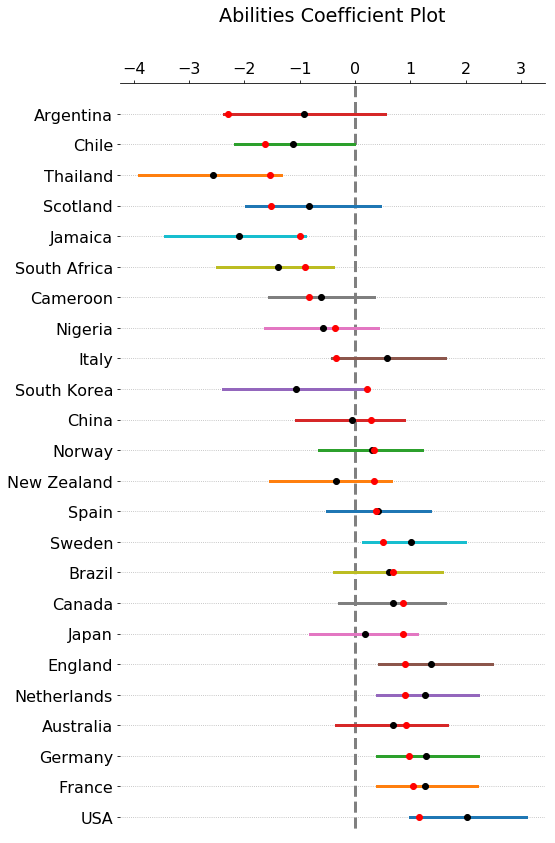

In [20]:
coefficient_plot(df_abilities['midway'], df_abilities['left'], 
                 df_abilities['right'], countries['prior_score'], 
                 names=df_abilities['names'],
                 title='Abilities Coefficient Plot',
                fig_size = (8,12))
plt.tight_layout()

<h2> 6. Let's Make Some Predictions! <a name="Pred"></a> </h2>

Here's what actually happened at the Semi-finals.

**The Semi-finals:** <br>
**1. England vs USA : 1-2**<br>
**2. Netherlands vs Sweden: 1-0**<br>

We are going to generate these matches using Stan and get the score-differentials. This is similar to what we did in the previous section: instead of "replaying" all the matches based on the tournament simulations, we are going to "play" the semi-finals and get the score differentials. Since we're a good month ahead of the events, we have the actual data for these matches and we get to assess how good our predictions are!


In [21]:
semis_dict = dict({'team_1': ['England', 'Netherlands'],
                 'team_2': ['USA', 'Sweden'],
                   'match_list': ['England vs USA', 'Netherlands vs Sweden'],
                  'actual_score_differential': [-1, 1]})

semis_dict['team_1'] = [ country_mapping.get(x) for x in semis_dict['team_1']]
semis_dict['team_2'] = [ country_mapping.get(x) for x in semis_dict['team_2']]
semis_dict

{'team_1': [6, 5],
 'team_2': [1, 10],
 'match_list': ['England vs USA', 'Netherlands vs Sweden'],
 'actual_score_differential': [-1, 1]}

In [22]:
mydict.update({'team_1_semis':[6, 5],
                'team_2_semis':[1, 10]})

In [30]:
mydict

{'I': 24,
 'N': 48,
 'team_1': [2,
  3,
  11,
  13,
  4,
  9,
  6,
  24,
  8,
  12,
  23,
  1,
  17,
  3,
  2,
  4,
  19,
  7,
  20,
  6,
  5,
  8,
  10,
  1,
  14,
  19,
  17,
  15,
  16,
  20,
  21,
  7,
  18,
  5,
  10,
  22,
  3,
  13,
  6,
  2,
  11,
  10,
  16,
  5,
  13,
  2,
  16,
  3],
 'team_2': [15,
  14,
  19,
  17,
  16,
  20,
  21,
  7,
  18,
  5,
  10,
  22,
  15,
  11,
  13,
  9,
  14,
  21,
  16,
  24,
  18,
  12,
  22,
  23,
  11,
  3,
  2,
  13,
  9,
  4,
  24,
  6,
  12,
  8,
  1,
  23,
  17,
  4,
  18,
  9,
  1,
  8,
  14,
  7,
  6,
  1,
  5,
  10],
 'score_1': [4.0,
  1.0,
  3.0,
  3.0,
  1.0,
  3.0,
  2.0,
  0.0,
  1.0,
  0.0,
  0.0,
  13.0,
  2.0,
  1.0,
  2.0,
  3.0,
  0.0,
  2.0,
  0.0,
  1.0,
  3.0,
  2.0,
  5.0,
  3.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  3.0,
  0.0,
  2.0,
  2.0,
  0.0,
  0.0,
  3.0,
  1.0,
  3.0,
  2.0,
  1.0,
  1.0,
  2.0,
  2.0,
  0.0,
  1.0,
  0.0,
  1.0],
 'score_2': [0.0,
  0.0,
  1.0,
  0.0,
  2.0,
  0.0,
  1.0,
  0.0,
  0.0,


In [24]:
stan_wc_semis = Model(stan_file='../models/worldcup_semis.stan')
stan_wc_semis.compile()
stan_wc_semis

INFO:cmdstanpy:compiling c++
INFO:cmdstanpy:compiled model file: /Users/nitya/Work/2019-cmdstanpy-bayesian-workshop/models/worldcup_semis


Model(name=worldcup_semis,  stan_file="../models/worldcup_semis.stan", exe_file="/Users/nitya/Work/2019-cmdstanpy-bayesian-workshop/models/worldcup_semis")

In [25]:
worldcup_semis_fit = stan_wc_semis.sample(data=mydict, chains=4)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


In [26]:
worldcup_semis_fit.diagnose()


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmpqa3kddk_/stan-worldcup_semis-draws-1-88tqrz6u.csv, /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmpqa3kddk_/stan-worldcup_semis-draws-2-zvorg36c.csv, /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmpqa3kddk_/stan-worldcup_semis-draws-3-xo2mht2d.csv, /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmpqa3kddk_/stan-worldcup_semis-draws-4-d2c8v7yh.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

In [27]:
#We can re-do our entire analysis discussed in the previous section, but just for these two matches!
df_semis = worldcup_semis_fit.summary().round(decimals = 2)
dft_semis = df_semis.transpose()
semi_filter = [col for col in dft_semis if col.startswith('semi')]
td_semis = dft_semis[semi_filter]

In [28]:
df_teamdifferentials_semis = pd.DataFrame({'midway': td_semis.loc['50%'].values,
                                       'names':semis_dict['match_list']})
df_teamdifferentials_semis.loc[:, 'left'] = td_semis.loc['5%'].values
df_teamdifferentials_semis.loc[:, 'right'] = td_semis.loc['95%'].values

/Users/nitya/miniconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


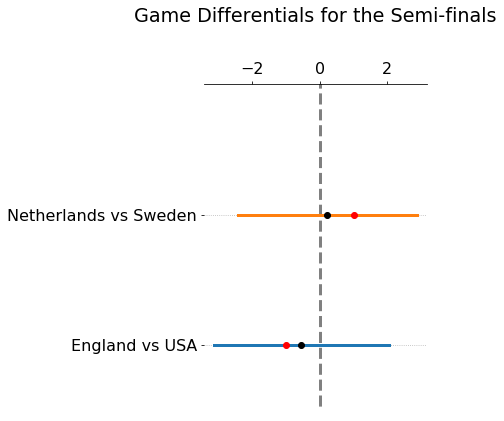

In [29]:
coefficient_plot(df_teamdifferentials_semis['midway'], 
                          df_teamdifferentials_semis['left'], 
                          df_teamdifferentials_semis['right'], 
                          np.array(semis_dict['actual_score_differential']),
                          names=df_teamdifferentials_semis['names'], 
                          title='Game Differentials for the Semi-finals', 
                          fig_size = (4,6))
plt.tight_layout()

<h2> 7. Make your own tournament! <a name="Exercises"></a> </h2>

<center><h2>  </h2></center>